# Abnormal Heartbeat Detection using Deep Learning

My interest in human performance and wearable sensors motivated me to build my data science project portfolio with projects related to physiological data. A lot of physiological data such as heartbeat signals, gait data, or angular velocities derived from inertial measurement units are in the form of time series data. Time series data are a sequence of datapoints indexed in time order. Analyzing this type of data, as opposed to cross sectional or singular data points, require different analysis approaches. I thought that exploring a dataset of heartbeat signals recorded from ECG would be a great learning experience for building my skillset in analyzing time series data. Specifically, this project uses a neural network to detect anomalies in heartbeat sound signals. Using AI and ML algorithms in parallel with doctors’ expertise can help to detect abnormal signals accurately and efficiently. Let’s get started.

### Research Problem Identification

As with any data science or research project, identifying the problem is a good place to begin. Cardiovascular disease is a major cause of mortality, but early detection of disease can help doctors develop plans to reduce the risk of cardiovascular disease related death. Given that abnormal heartbeat signals are an indicator of cardiovascular disease, early detection of anomalies could help clinicians diagnose these diseases early on. Therefore, the aim of this project is to build machine learning models that can detect abnormal heartbeat signals, which would help clinicians with early detection of cardiovascular disease. 

### Dataset

This dataset came from Cainvas AI (https://cainvas.ai-tech.systems/accounts/login/). It consists of .wav files (.wav files are time series signals originally created for sound bites and sound clips) with four "types" of signals:

1) Artifact - non heartbeat sounds<br>
2) Extrahls - normal heartbeats with additional sounds<br>
3) Murmur - blowing, whooshing, or rasping sound caused by turbulent bloodflow through the heart<br>
4) Normal - healthy signal<br>

Artifacts, extrahls, and murmurs are abnormal signals that may be a cause of concern for clinicians, so detecting these early would be beneficial for early disease diagnosis. (credit to Almanifi et al. - Heartbeat murmurs detection in phonocardiogram recordings via transfer learning (2022) for the definitions)

### Libraries

In [44]:
#standard libraries
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import pandas as pd

#scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

#deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'

#audio file processing
import librosa
import librosa.display
import wave

#ignoring warnings
import warnings                       
warnings.filterwarnings("ignore")

# gather software versions
import tensorflow as tf
import keras

Populating the interactive namespace from numpy and matplotlib


### Create a usable dataset from the .wav files 

In [31]:
#empty dataset
HB_dataset = []
#loop over files in hearbeat data
for filename in glob.iglob(os.getcwd()+'/heart/set_a/**'):
    if os.path.exists(filename):
        #assign label to everything before the first underscore of the file name
        label = os.path.basename(filename).split("_")[0]
        #skip files that < 4 seconds
        if librosa.get_duration(filename=filename)>=4:
            #do not included unlabelled (ie test) files
            if label not in ['Aunlabelledtest']:
                HB_dataset.append({'filename':filename, 'label':label})
                
                
#convert dataset to pandas dataframe
HB_dataset = pd.DataFrame(HB_dataset)

#display dataset
HB_dataset

,filename,label
0,/Users/rossbrancati/Desktop/Projects/heartbeat...,normal
1,/Users/rossbrancati/Desktop/Projects/heartbeat...,artifact
2,/Users/rossbrancati/Desktop/Projects/heartbeat...,extrahls
3,/Users/rossbrancati/Desktop/Projects/heartbeat...,murmur
4,/Users/rossbrancati/Desktop/Projects/heartbeat...,murmur
...,...,...
88,/Users/rossbrancati/Desktop/Projects/heartbeat...,artifact
89,/Users/rossbrancati/Desktop/Projects/heartbeat...,artifact
90,/Users/rossbrancati/Desktop/Projects/heartbeat...,artifact
91,/Users/rossbrancati/Desktop/Projects/heartbeat...,artifact


### Exploratory Data Analysis

First, lets explore the distribution of data

Distribution of Hearbeat Signals
murmur      28
artifact    25
normal      25
extrahls    15
Name: label, dtype: int64
Total Number of Samples: 93


<AxesSubplot:>

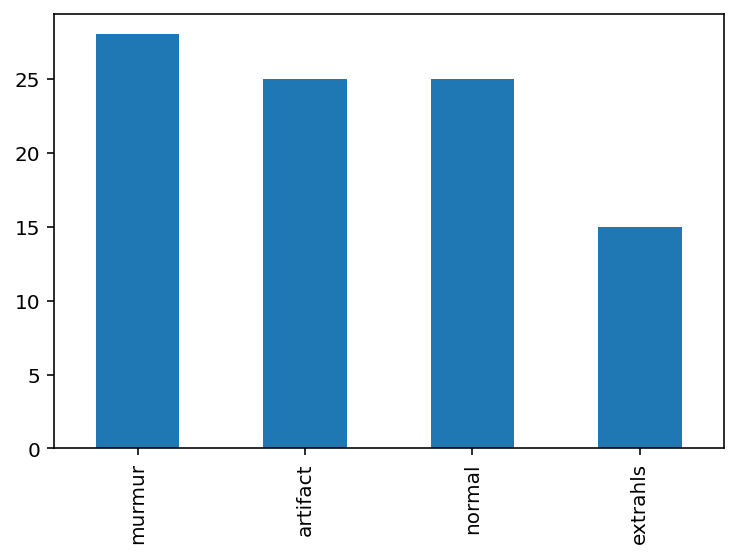

In [43]:
#get counts of each type and plot
print("Distribution of Hearbeat Signals")
counts = HB_dataset.label.value_counts()
print(counts)
print("Total Number of Samples:", sum(counts))
plt.figure()
counts.plot(kind="bar")

We have 93 total samples for training and validation data, distributed fairly evenly, except for the extrahls where we only have 15 samples. Lets also plot the waveform as a function of time.

### Normal

In [56]:
normal_HB_signal = os.getcwd()+"/heart/set_a/normal__201102260502.wav"
#load a sample normal wave and calculate sampling rate, total number of samples, and duration
normal_wave = wave.open(normal_HB_signal)
print("Sampling rate: ", normal_wave.getframerate())
print("Total samples: ", normal_wave.getnframes())
print("Duration: ", normal_wave.getnframes()/normal_wave.getframerate())

Sampling rate:  44100
Total samples:  277130
Duration:  6.284126984126984


duration: 6.0
(132300,) 22050


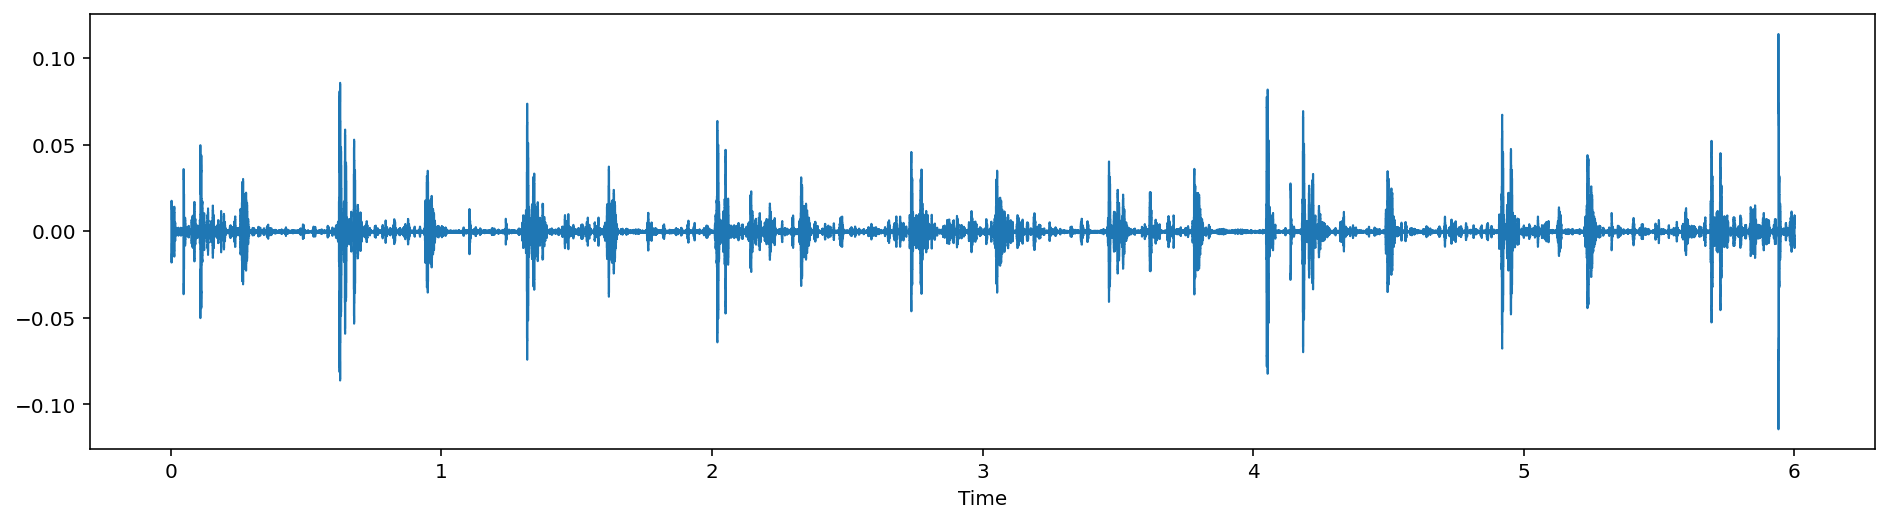

In [58]:
#load file using librosa 
y_N, sr_N = librosa.load(normal_HB_signal, duration=6)   
dur_N = librosa.get_duration(y_N)
print ("duration:", dur_N)
print(y_N.shape, sr_N)

#plot signal
plt.figure(figsize=(16,4))
librosa.display.waveshow(y_N, sr=sr_N)

### Murmur

In [57]:
murmur_HB_signal = os.getcwd()+"/heart/set_a/murmur__201102052338.wav"
#load a sample normal wave and calculate sampling rate, total number of samples, and duration
murmur_wave = wave.open(murmur_HB_signal)
print("Sampling rate: ", murmur_wave.getframerate())
print("Total samples: ", murmur_wave.getnframes())
print("Duration: ", murmur_wave.getnframes()/murmur_wave.getframerate())

Sampling rate:  44100
Total samples:  396900
Duration:  9.0


duration: 9.0
(198450,) 22050


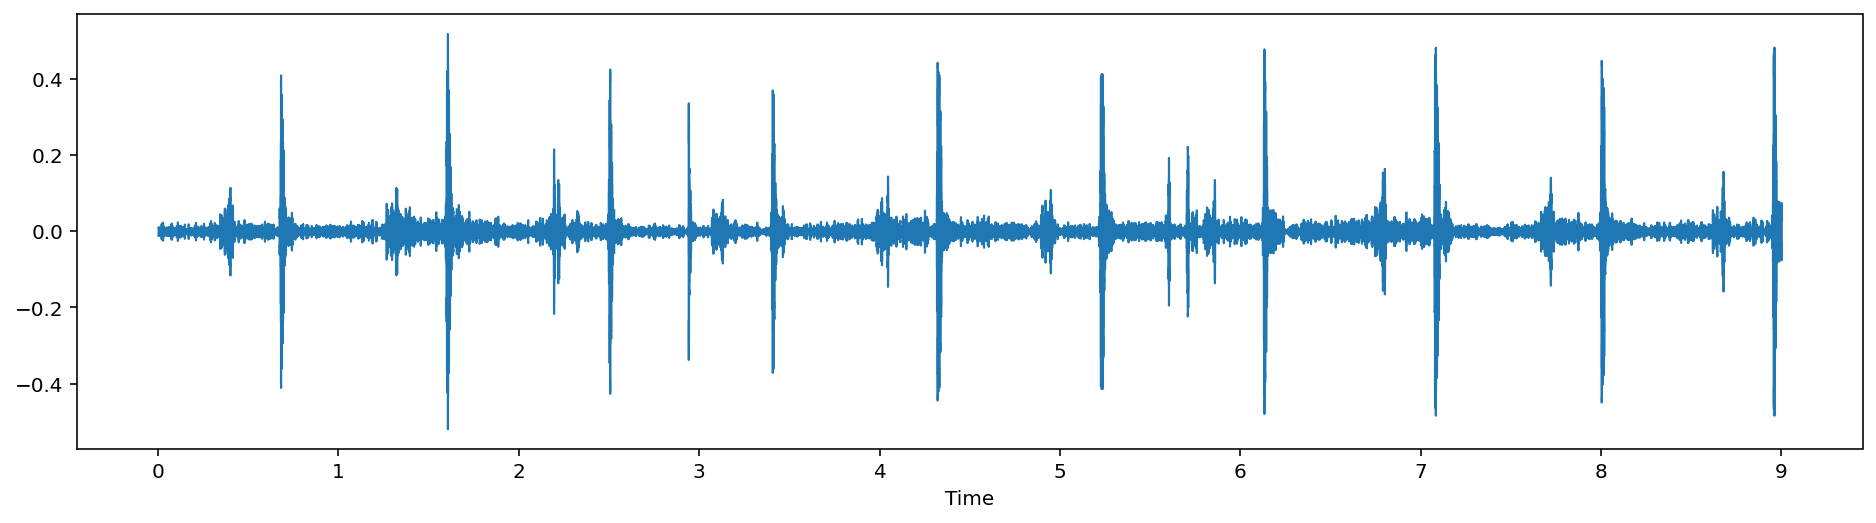

In [60]:
#load file using librosa 
y_M, sr_M = librosa.load(murmur_HB_signal, duration=9)   
dur_M = librosa.get_duration(y_M)
print ("duration:", dur_M)
print(y_M.shape, sr_M)

#plot signal
plt.figure(figsize=(16,4))
librosa.display.waveshow(y_M, sr=sr_M)

### Artifact

In [70]:
artifact_HB_signal = os.getcwd()+"/heart/set_a/artifact__201012172012.wav"
#load a sample normal wave and calculate sampling rate, total number of samples, and duration
artifact_wave = wave.open(artifact_HB_signal)
print("Sampling rate: ", artifact_wave.getframerate())
print("Total samples: ", artifact_wave.getnframes())
print("Duration: ", artifact_wave.getnframes()/artifact_wave.getframerate())

Sampling rate:  44100
Total samples:  396900
Duration:  9.0


duration: 9.0
(198450,) 22050


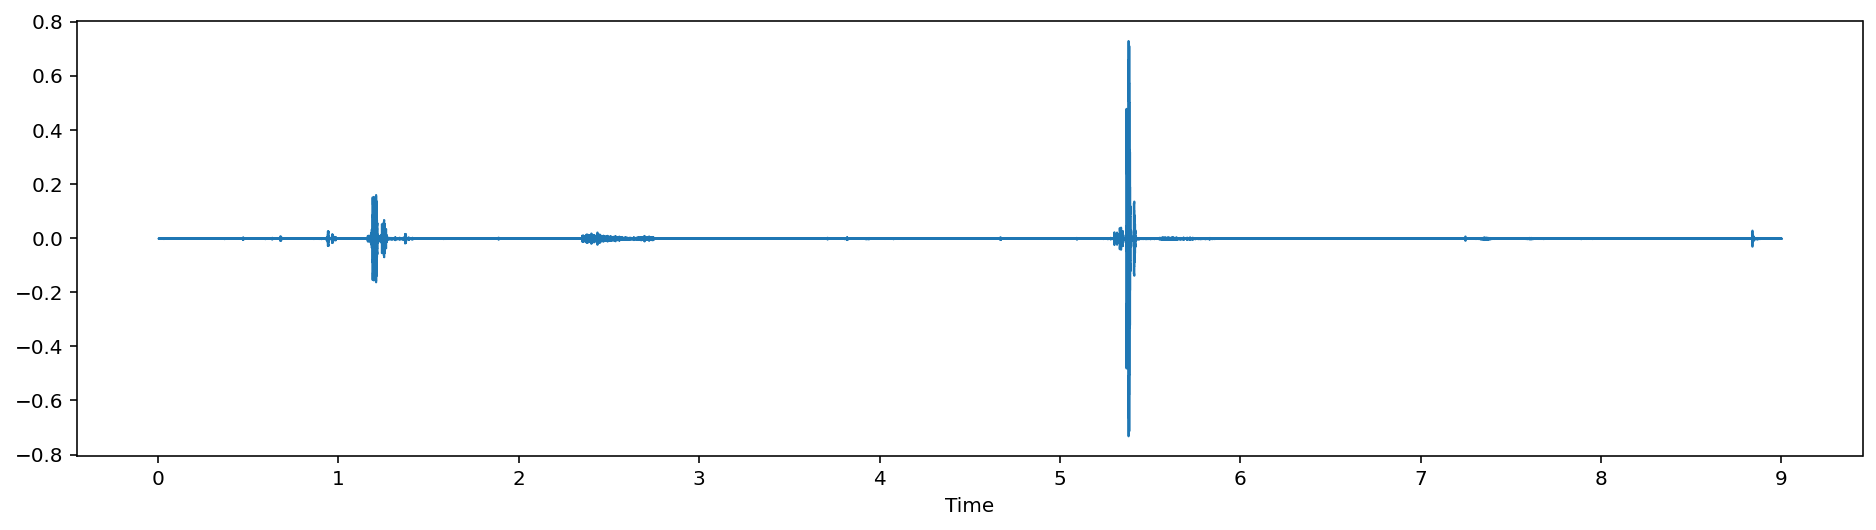

In [71]:
#load file using librosa 
y_A, sr_A = librosa.load(artifact_HB_signal, duration=9)   
dur_A = librosa.get_duration(y_A)
print ("duration:", dur_A)
print(y_A.shape, sr_A)

#plot signal
plt.figure(figsize=(16,4))
librosa.display.waveshow(y_A, sr=sr_A)

### Extrahl

In [74]:
extrahl_HB_signal = os.getcwd()+"/heart/set_a/extrahls__201101070953.wav"
#load a sample normal wave and calculate sampling rate, total number of samples, and duration
extrahl_wave = wave.open(extrahl_HB_signal)
print("Sampling rate: ", extrahl_wave.getframerate())
print("Total samples: ", extrahl_wave.getnframes())
print("Duration: ", extrahl_wave.getnframes()/extrahl_wave.getframerate())

Sampling rate:  44100
Total samples:  391787
Duration:  8.8840589569161


duration: 8.88408163265306
(195894,) 22050


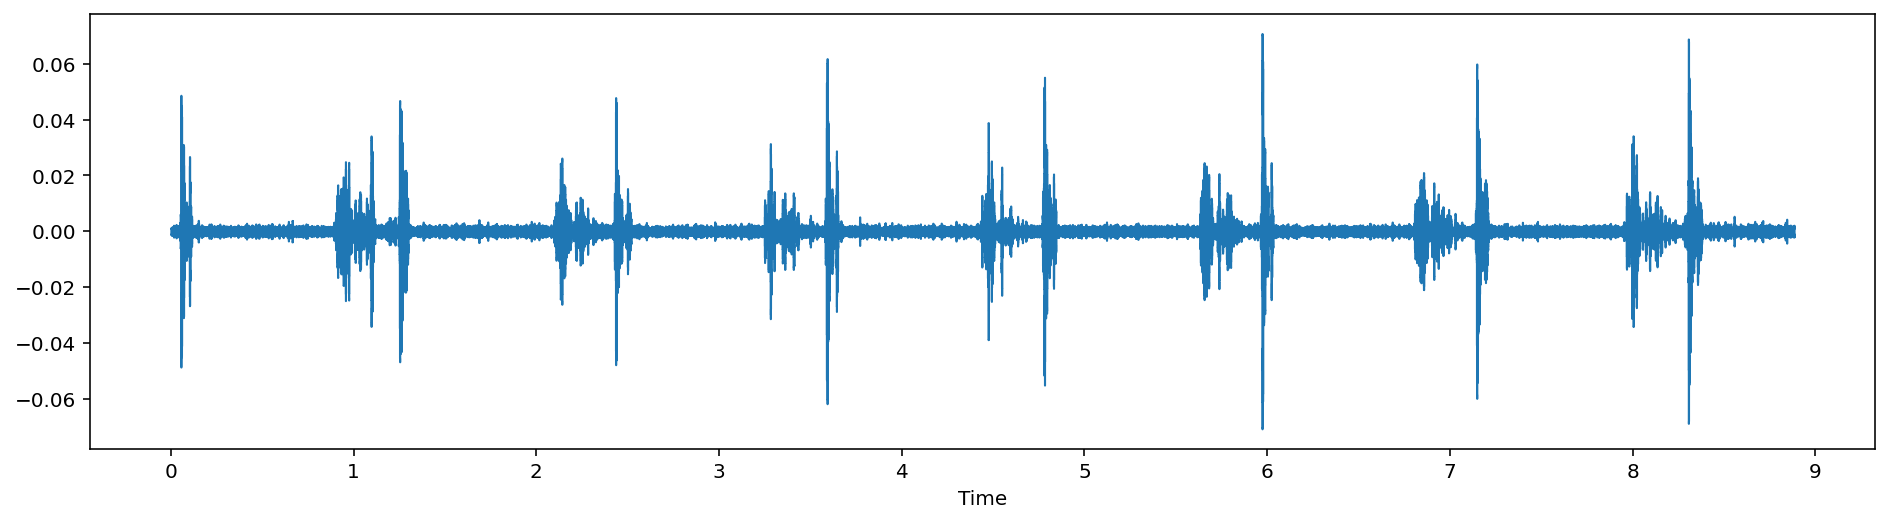

In [75]:
#load file using librosa 
y_E, sr_E = librosa.load(extrahl_HB_signal, duration=9)   
dur_E = librosa.get_duration(y_E)
print ("duration:", dur_E)
print(y_E.shape, sr_E)

#plot signal
plt.figure(figsize=(16,4))
librosa.display.waveshow(y_E, sr=sr_E)

From the visual perspective, the signals have different shapes and different intervals between spikes in the signals. The next step is to use a deep learning model to classify these signals into their respective category.

### Data Preprocessing

In [138]:
#split training and testing data (80% train, 20% testing)
train, test = train_test_split(HB_dataset, test_size=0.2, random_state=42)

#get number of samples in training and testing sets
print("Training: %i" % len(train))
print("Testing: %i" % len(test))

Training: 74
Testing: 19


The librosa package has a built in function to extract the mel frequency cepstrum coefficients (MFCCs). MFCCs are coefficients that represent short term power spectrums of sound. Learn more about MFCCs here (https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

In [139]:
#extract features from files
def extract_features(file_path):
    #standardize all durations to 4
    y, sr = librosa.load(file_path, duration=4)
    #setting the number of MFCCs to 40 will generate 40 coefficients
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [140]:
#create x_train and x_test datasets
x_train = []
x_test = []

print('Training Data:')
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))
    
print("Testing Data:")
for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))

  1%|▏         | 1/74 [00:00<00:10,  7.08it/s]

Training Data:


  5%|▌         | 1/19 [00:00<00:02,  7.17it/s]

Testing Data:


100%|██████████| 19/19 [00:02<00:00,  8.27it/s]


In [141]:
#convert to np arrays to train model
X_test = np.asarray(x_test)
X_train = np.asarray(x_train)

print("Training Data Shape: ", X_train.shape)
print("Testing Data Shape: ", X_test.shape)

Training Data Shape:  (74, 40, 173)
Testing Data Shape:  (19, 40, 173)


74 and 19 samples of training and testing data, respectively, where each sample is 40 rows and 173 columns.

In [142]:
#endode labels (i.e., convert labels to numbers)
encoder = LabelEncoder()
encoder.fit(train.label)

#assign y_train and y_test
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

In [143]:
#reshape X_train and X_test to match input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

#Convert y_train and y_test to categorical variables 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [144]:
#display shapes of training and testing data to confirm that dimensions match
print("X train:", X_train.shape)
print("Y train:", y_train.shape)
print("----------------------------")
print("X test:", X_test.shape)
print("Y test:", y_test.shape)

X train: (74, 40, 173, 1)
Y train: (74, 4)
----------------------------
X test: (19, 40, 173, 1)
Y test: (19, 4)


Now that all of the data is pre-processed, we can start building and testing the model.

### Build Neural Network

In [145]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 41, 64)         8256      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 20, 64)        

In [146]:
#compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr = 0.001))

Now that the model is built, we must fit it with the input data.

### Fit Model

In [147]:
history = model.fit(X_train, y_train, batch_size=256, epochs=300, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 2.3890 - accuracy: 0.2973 - val_loss: 2.4501 - val_accuracy: 0.3158
Epoch 2/300
1/1 [==============================] - 0s 281ms/step - loss: 3.5923 - accuracy: 0.2838 - val_loss: 1.7768 - val_accuracy: 0.3158
Epoch 3/300
1/1 [==============================] - 0s 260ms/step - loss: 2.5469 - accuracy: 0.2838 - val_loss: 1.4536 - val_accuracy: 0.3684
Epoch 4/300
1/1 [==============================] - 0s 268ms/step - loss: 1.6273 - accuracy: 0.4865 - val_loss: 1.3924 - val_accuracy: 0.4211
Epoch 5/300
1/1 [==============================] - 0s 271ms/step - loss: 1.6040 - accuracy: 0.5405 - val_loss: 1.2378 - val_accuracy: 0.5263
Epoch 6/300
1/1 [==============================] - 0s 263ms/step - loss: 1.1340 - accuracy: 0.5676 - val_loss: 1.1415 - val_accuracy: 0.4211
Epoch 7/300
1/1 [==============================] - 0s 259ms/step - loss: 0.8954 - accuracy: 0.5676 - val_loss: 1.1172 - val_accuracy: 0.4211
Epoch 8/300
1/1 

Epoch 59/300
1/1 [==============================] - 0s 263ms/step - loss: 0.4638 - accuracy: 0.8108 - val_loss: 0.7603 - val_accuracy: 0.6316
Epoch 60/300
1/1 [==============================] - 0s 283ms/step - loss: 0.4763 - accuracy: 0.7703 - val_loss: 0.7456 - val_accuracy: 0.6842
Epoch 61/300
1/1 [==============================] - 0s 250ms/step - loss: 0.4588 - accuracy: 0.7973 - val_loss: 0.7383 - val_accuracy: 0.6842
Epoch 62/300
1/1 [==============================] - 0s 244ms/step - loss: 0.4746 - accuracy: 0.7432 - val_loss: 0.7411 - val_accuracy: 0.6316
Epoch 63/300
1/1 [==============================] - 0s 252ms/step - loss: 0.4961 - accuracy: 0.7568 - val_loss: 0.7404 - val_accuracy: 0.6316
Epoch 64/300
1/1 [==============================] - 0s 248ms/step - loss: 0.4767 - accuracy: 0.7838 - val_loss: 0.7398 - val_accuracy: 0.6316
Epoch 65/300
1/1 [==============================] - 0s 267ms/step - loss: 0.4328 - accuracy: 0.7568 - val_loss: 0.7391 - val_accuracy: 0.6316
Epoch 

1/1 [==============================] - 0s 256ms/step - loss: 0.2949 - accuracy: 0.8649 - val_loss: 0.6161 - val_accuracy: 0.5789
Epoch 117/300
1/1 [==============================] - 0s 246ms/step - loss: 0.2828 - accuracy: 0.8919 - val_loss: 0.6097 - val_accuracy: 0.5789
Epoch 118/300
1/1 [==============================] - 0s 252ms/step - loss: 0.2692 - accuracy: 0.9459 - val_loss: 0.6377 - val_accuracy: 0.6316
Epoch 119/300
1/1 [==============================] - 0s 237ms/step - loss: 0.2287 - accuracy: 0.9054 - val_loss: 0.6962 - val_accuracy: 0.5789
Epoch 120/300
1/1 [==============================] - 0s 263ms/step - loss: 0.3405 - accuracy: 0.8514 - val_loss: 0.6913 - val_accuracy: 0.5789
Epoch 121/300
1/1 [==============================] - 0s 247ms/step - loss: 0.3480 - accuracy: 0.8919 - val_loss: 0.6241 - val_accuracy: 0.5789
Epoch 122/300
1/1 [==============================] - 0s 255ms/step - loss: 0.2861 - accuracy: 0.8649 - val_loss: 0.5703 - val_accuracy: 0.5789
Epoch 123/300

1/1 [==============================] - 0s 247ms/step - loss: 0.1938 - accuracy: 0.9054 - val_loss: 0.6762 - val_accuracy: 0.5789
Epoch 174/300
1/1 [==============================] - 0s 309ms/step - loss: 0.1820 - accuracy: 0.9189 - val_loss: 0.6439 - val_accuracy: 0.5789
Epoch 175/300
1/1 [==============================] - 0s 276ms/step - loss: 0.1495 - accuracy: 0.9730 - val_loss: 0.6366 - val_accuracy: 0.6842
Epoch 176/300
1/1 [==============================] - 0s 256ms/step - loss: 0.2275 - accuracy: 0.9054 - val_loss: 0.5808 - val_accuracy: 0.6316
Epoch 177/300
1/1 [==============================] - 0s 266ms/step - loss: 0.1597 - accuracy: 0.9324 - val_loss: 0.5861 - val_accuracy: 0.5789
Epoch 178/300
1/1 [==============================] - 0s 262ms/step - loss: 0.1749 - accuracy: 0.9459 - val_loss: 0.6215 - val_accuracy: 0.6316
Epoch 179/300
1/1 [==============================] - 0s 253ms/step - loss: 0.1766 - accuracy: 0.9324 - val_loss: 0.6083 - val_accuracy: 0.6842
Epoch 180/300

1/1 [==============================] - 0s 255ms/step - loss: 0.0737 - accuracy: 0.9730 - val_loss: 0.6958 - val_accuracy: 0.6316
Epoch 231/300
1/1 [==============================] - 0s 255ms/step - loss: 0.1374 - accuracy: 0.9459 - val_loss: 0.5294 - val_accuracy: 0.6842
Epoch 232/300
1/1 [==============================] - 0s 247ms/step - loss: 0.1011 - accuracy: 0.9459 - val_loss: 0.5247 - val_accuracy: 0.5789
Epoch 233/300
1/1 [==============================] - 0s 248ms/step - loss: 0.0819 - accuracy: 0.9730 - val_loss: 0.6126 - val_accuracy: 0.6316
Epoch 234/300
1/1 [==============================] - 0s 250ms/step - loss: 0.1272 - accuracy: 0.9324 - val_loss: 0.5816 - val_accuracy: 0.7368
Epoch 235/300
1/1 [==============================] - 0s 251ms/step - loss: 0.1545 - accuracy: 0.9459 - val_loss: 0.5289 - val_accuracy: 0.6842
Epoch 236/300
1/1 [==============================] - 0s 252ms/step - loss: 0.1111 - accuracy: 0.9865 - val_loss: 0.5162 - val_accuracy: 0.6316
Epoch 237/300

1/1 [==============================] - 0s 342ms/step - loss: 0.0779 - accuracy: 0.9595 - val_loss: 1.0984 - val_accuracy: 0.5789
Epoch 288/300
1/1 [==============================] - 0s 291ms/step - loss: 0.0886 - accuracy: 0.9595 - val_loss: 1.0945 - val_accuracy: 0.5263
Epoch 289/300
1/1 [==============================] - 0s 254ms/step - loss: 0.0698 - accuracy: 0.9730 - val_loss: 1.0291 - val_accuracy: 0.5789
Epoch 290/300
1/1 [==============================] - 0s 259ms/step - loss: 0.0848 - accuracy: 0.9595 - val_loss: 0.8921 - val_accuracy: 0.5789
Epoch 291/300
1/1 [==============================] - 0s 314ms/step - loss: 0.0528 - accuracy: 0.9865 - val_loss: 0.8527 - val_accuracy: 0.5789
Epoch 292/300
1/1 [==============================] - 0s 324ms/step - loss: 0.0736 - accuracy: 0.9730 - val_loss: 0.8888 - val_accuracy: 0.5789
Epoch 293/300
1/1 [==============================] - 0s 305ms/step - loss: 0.0898 - accuracy: 0.9324 - val_loss: 0.8728 - val_accuracy: 0.5789
Epoch 294/300

The network produced a validation accuracy of 63.16% on the validation (test) set. It is always good practice to plot the loss (a measure of model performance) and accuracy.

### Loss Curves

Text(0, 0.5, 'Loss')

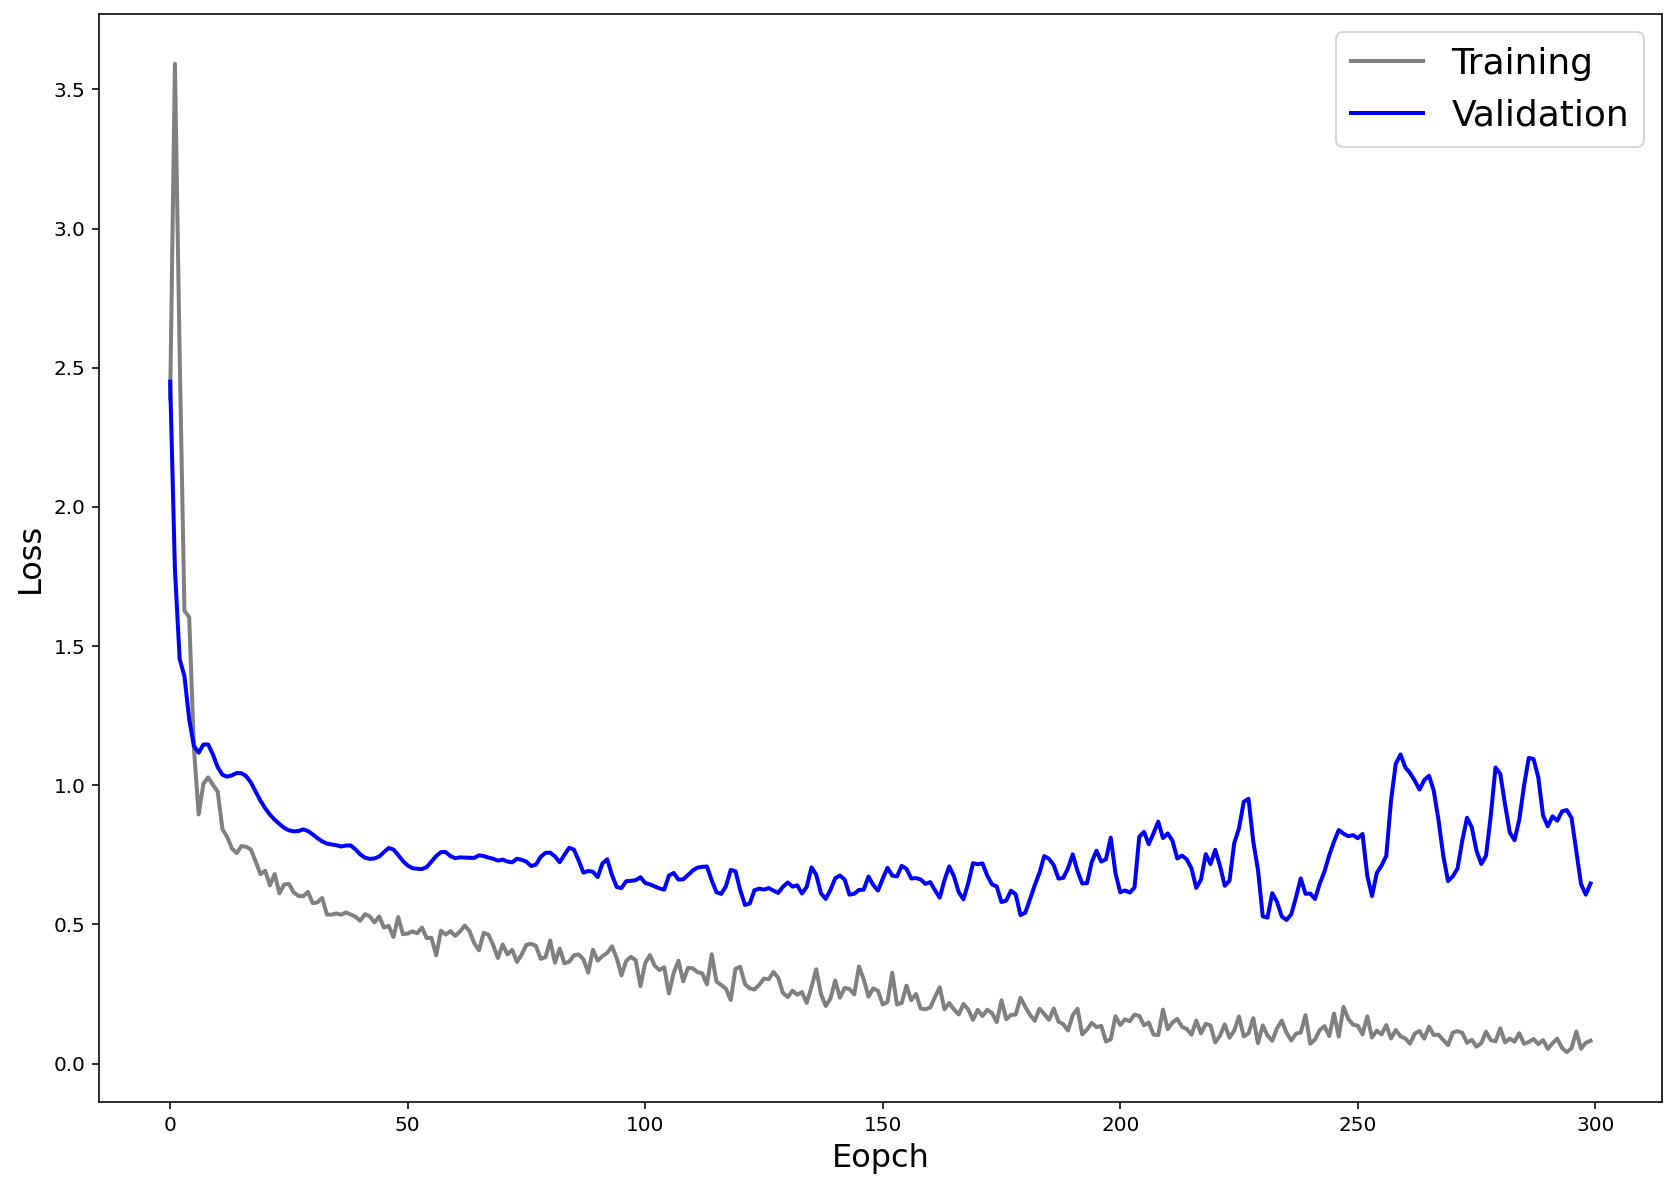

In [148]:
plt.figure(figsize=[14,10])
plt.plot(history.history['loss'], 'gray', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training', 'Validation'],fontsize=18)
plt.xlabel('Eopch',fontsize=16)
plt.ylabel('Loss',fontsize=16)

### Accuracy Curves

Text(0, 0.5, 'Loss')

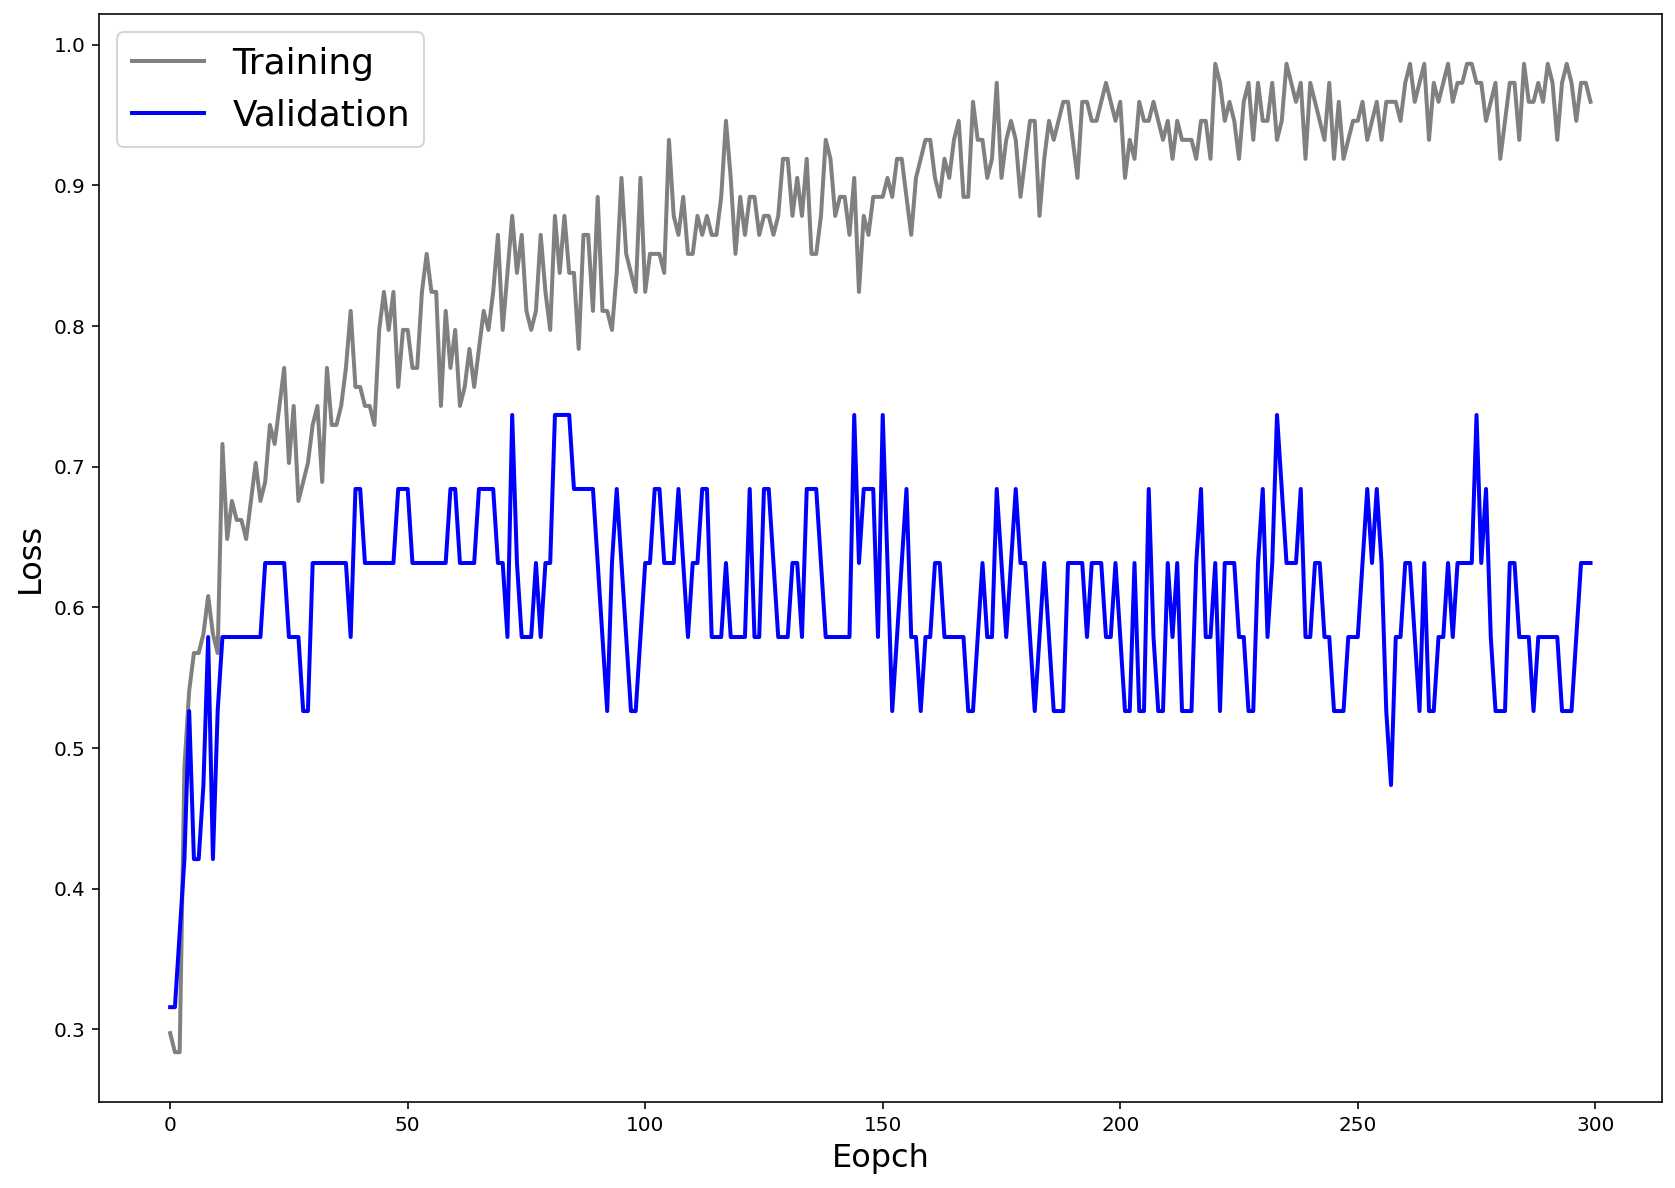

In [149]:
plt.figure(figsize=[14,10])
plt.plot(history.history['accuracy'], 'gray', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training', 'Validation'],fontsize=18)
plt.xlabel('Eopch',fontsize=16)
plt.ylabel('Loss',fontsize=16)

### Save, evaluate, and test the model on new data.

In [150]:
#save the model
model.save("HD_model")

INFO:tensorflow:Assets written to: HD_model/assets


In [151]:
#evaluate model
test_scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

1/1 [==============================] - 0s 36ms/step - loss: 0.6472 - accuracy: 0.6316
Test loss: 0.6471784114837646
Test accuracy: 0.6315789222717285


In [154]:
#generate predictions
predictions = model.predict(X_test, verbose=1)

#get predictions and true labels
Y_pred = predictions.argmax(axis=-1)
Y_test = y_test.argmax(axis=-1)

#encode predictions and true labels and display in dataframe
Y_pred = encoder.inverse_transform(Y_pred)
Y_test = encoder.inverse_transform(Y_test)

df = pd.DataFrame(columns=['Predictions', 'True Labels'])
df['Predictions'] = Y_pred.flatten()
df['True Labels'] = Y_test.flatten()

1/1 [==============================] - 0s 38ms/step


In [155]:
df

,Predictions,True Labels
0,extrahls,extrahls
1,normal,normal
2,artifact,artifact
3,artifact,normal
4,normal,normal
5,murmur,normal
6,normal,murmur
7,murmur,normal
8,artifact,artifact
9,murmur,murmur


Errors came from the following indices: 3, 5, 6, 7, 10, 13 & 16. This demonstrates that AI is not going to completely replace doctor diagnosis, unless we are able to build models with much greater accuracy. The findings should be taken with caution because incorrectly classifying a murmur as normal could be dangerous for a patient. 